# HW2 Spam Classification with LSTM model

The deadline is **2 pm Feb 25, 2021**.   
You should submit a `.ipynb` file with your solutions to NYU Brightspace.

---

In this homework, we will reuse the spam prediction dataset used in HW1.
We will use a word-level BiLSTM sentence encoder to encode the sentence and a neural network classifier.

For reference, you may read [this paper](https://arxiv.org/abs/1705.02364).

Content of this HW is related with Lab 3 Deep Learning.

## Points distribution

1. code `spam_collate_func`: 25 pts
2. code `LSTMClassifier.init`: 25 pts
3. code `LSTMClassifier.forward`: 20 pts
4. code `evaluate`: 10 pts
5. code for training loop: 10 pts
6. Question: `Why do we want to use early stopping?`: 10 pts

How we grade the code: 
- full points if code works and the underlying logic is correct;
- half points if code works but the underlying logic is incorrect;
- zero points if code does not work.

TLDR: **make sure your code works, i.e. no errors are being produced when you call the function (not when you defined it in the cell!).**

How we grade the open question:
* full points if your answer follows lecture materials.
* zero points if your answer contradicts lecture materials.

# Data Loading
First, reuse the code from HW1 to download and read the data.

In [1]:
!wget 'https://docs.google.com/uc?export=download&id=1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR' -O spam.csv

--2021-02-25 13:25:29--  https://docs.google.com/uc?export=download&id=1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR
Resolving docs.google.com (docs.google.com)... 216.58.200.174
Connecting to docs.google.com (docs.google.com)|216.58.200.174|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/b55qcmfsdoagrc7d7kslprmpkb8qmlvg/1614239700000/08752484438609855375/*/1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR?e=download [following]
--2021-02-25 13:25:30--  https://doc-14-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/b55qcmfsdoagrc7d7kslprmpkb8qmlvg/1614239700000/08752484438609855375/*/1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR?e=download
Resolving doc-14-04-docs.googleusercontent.com (doc-14-04-docs.googleusercontent.com)... 172.217.31.1
Connecting to doc-14-04-docs.googleusercontent.com (doc-14-04-docs.googleusercontent.com)|172.217.31.1|:443... connected.
HTTP

In [2]:
import torch 
print(torch.__version__)

1.7.1


In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("spam.csv", usecols=["v1", "v2"], encoding='latin-1')
# 1 - spam, 0 - ham
df.v1 = (df.v1 == "spam").astype("int")
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


We will split the data into train, val, and test sets.  
`train_texts`, `val_texts`, and `test_texts` should contain a list of text examples in the dataset.


In [4]:
# 0.15 for val, 0.15 for test, 0.7 for train
val_size = int(df.shape[0] * 0.15)
test_size = int(df.shape[0] * 0.15)

# Shuffle the data
df = df.sample(frac=1)
# Split df to test/val/train
test_df = df[:test_size]
val_df = df[test_size:test_size+val_size]
train_df = df[test_size+val_size:]


train_texts, train_labels = list(train_df.v2), list(train_df.v1)
val_texts, val_labels     = list(val_df.v2), list(val_df.v1)
test_texts, test_labels   = list(test_df.v2), list(test_df.v1)


# Check that idces do not overlap
assert set(train_df.index).intersection(set(val_df.index)) == set({})
assert set(test_df.index).intersection(set(train_df.index)) == set({})
assert set(val_df.index).intersection(set(test_df.index)) == set({})
# Check that all idces are present
assert df.shape[0] == len(train_labels) + len(val_labels) + len(test_labels)
1
# Sizes
print(
    f"Size of initial data: {df.shape[0]}\n"
    f"Train size: {len(train_labels)}\n"
    f"Val size: {len(val_labels)}\n"
    f"Test size: {len(test_labels)}\n"
)

Size of initial data: 5572
Train size: 3902
Val size: 835
Test size: 835



In [5]:
train_texts[:10] # Just checking the examples in train_text

['We are at grandmas. Oh dear, u still ill? I felt Shit this morning but i think i am just hungover! Another night then. We leave on sat.',
 "Oh dang! I didn't mean o send that to you! Lol!",
 'Do u konw waht is rael FRIENDSHIP Im gving yuo an exmpel: Jsut ese tihs msg.. Evrey splleing of tihs msg is wrnog.. Bt sitll yuo can raed it wihtuot ayn mitsake.. GOODNIGHT &amp; HAVE A NICE SLEEP..SWEET DREAMS..',
 "It could work, we'll reach a consensus at the next meeting",
 "Tell me they're female :V how're you throwing in? We're deciding what all to get now",
 "The world's most happiest frnds never have the same characters... Dey just have the best understanding of their differences...",
 'You are a very very very very bad girl. Or lady.',
 'Hmmm.still we dont have opener?',
 'Free msg: Single? Find a partner in your area! 1000s of real people are waiting to chat now!Send CHAT to 62220Cncl send STOPCS 08717890890å£1.50 per msg',
 'Its a valentine game. . . Send dis msg to all ur friends. ..

# Download and Load GloVe Embeddings
We will use GloVe embedding parameters to initialize our layer of word representations / embedding layer.
Let's download and load glove.


This is related Lab 3 Deep Learning, please watch the recording and check the notebook for details.


In [6]:
#@title Download GloVe word embeddings

# === Download GloVe word embeddings
# !wget http://nlp.stanford.edu/data/glove.6B.zip

# === Unzip word embeddings and use only the top 50000 word embeddings for speed
# !unzip glove.6B.zip
# !head -n 50000 glove.6B.300d.txt > glove.6B.300d__50k.txt

# === Download Preprocessed version
!wget https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu -O glove_split.aa
!wget https://docs.google.com/uc?id=1LF2yD2jToXriyD-lsYA5hj03f7J3ZKaY -O glove_split.ab
!wget https://docs.google.com/uc?id=1N1xnxkRyM5Gar7sv4d41alyTL92Iip3f -O glove_split.ac
!cat glove_split.?? > 'glove.6B.300d__50k.txt'

--2021-02-25 13:25:40--  https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu
Resolving docs.google.com (docs.google.com)... 216.58.200.174
Connecting to docs.google.com (docs.google.com)|216.58.200.174|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8cp2tgoh5b5pcfru6spr1p3m7df5fsot/1614239700000/14514704803973256873/*/1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu [following]
--2021-02-25 13:25:45--  https://doc-0k-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8cp2tgoh5b5pcfru6spr1p3m7df5fsot/1614239700000/14514704803973256873/*/1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu
Resolving doc-0k-0g-docs.googleusercontent.com (doc-0k-0g-docs.googleusercontent.com)... 216.58.200.161
Connecting to doc-0k-0g-docs.googleusercontent.com (doc-0k-0g-docs.googleusercontent.com)|216.58.200.161|:443... connected.
HTTP request sent, awaiting response..

## Load GloVe Embeddings

In [7]:
def load_glove(glove_path, embedding_dim):
    with open(glove_path) as f:
        token_ls = [PAD_TOKEN, UNK_TOKEN]
        embedding_ls = [np.zeros(embedding_dim), np.random.rand(embedding_dim)]
        for line in f:
            token, raw_embedding = line.split(maxsplit=1)
            token_ls.append(token)
            embedding = np.array([float(x) for x in raw_embedding.split()])
            embedding_ls.append(embedding)
        embeddings = np.array(embedding_ls)
    return token_ls, embeddings

PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'
EMBEDDING_DIM=300 # dimension of Glove embeddings
glove_path = "glove.6B.300d__50k.txt"
vocab, embeddings = load_glove(glove_path, EMBEDDING_DIM)

## Import packages

In [8]:
!pip install sacremoses

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import pandas as pd
import sacremoses
from torch.utils.data import dataloader, Dataset
from tqdm.auto import tqdm

# Tokenize text data.
We will use the `tokenize` function to convert text data into sequence of indices.

In [9]:
def tokenize(data, labels, tokenizer, vocab, max_seq_length=128):
    vocab_to_idx = {word: i for i, word in enumerate(vocab)}
    text_data = []
    label_data = []
    for ex in tqdm(data):
        tokenized = tokenizer.tokenize(ex.lower())
        ids = [vocab_to_idx.get(token, 1) for token in tokenized]
        text_data.append(ids)
    return text_data, labels
tokenizer = sacremoses.MosesTokenizer()
train_data_indices, train_labels = tokenize(train_texts, train_labels, tokenizer, vocab)
val_data_indices, val_labels = tokenize(val_texts, val_labels, tokenizer, vocab)
test_data_indices, test_labels = tokenize(test_texts, test_labels, tokenizer, vocab)

  0%|          | 0/3902 [00:00<?, ?it/s]

  0%|          | 0/835 [00:00<?, ?it/s]

  0%|          | 0/835 [00:00<?, ?it/s]

In [10]:
print("\nTrain text first 5 examples:\n", train_data_indices[:5])
print("\nTrain labels first 5 examples:\n", train_labels[:5])


Train text first 5 examples:
 [[55, 34, 24, 1, 3204, 8609, 3, 6481, 151, 3120, 190, 43, 1351, 34857, 39, 768, 36, 43, 271, 43, 915, 122, 1, 807, 172, 366, 1, 55, 893, 15, 3225, 4], [3204, 35550, 807, 43, 1, 1, 1704, 4870, 1547, 14, 6, 83, 807, 1, 807], [90, 6481, 1, 1, 16, 1, 4583, 14665, 1, 1, 31, 1, 47, 1, 47746, 1, 36523, 1, 1, 1, 5, 1, 36523, 16, 1, 1, 7671, 1, 1, 88, 40937, 22, 1, 1, 1, 1, 41255, 725, 8459, 91, 35, 9, 3084, 4296, 1, 3716, 5561, 1], [22, 96, 163, 3, 55, 1, 1024, 9, 4129, 24, 2, 184, 288], [1363, 287, 41, 1, 1634, 47, 2406, 199, 1, 83, 4560, 8, 190, 55, 1, 6072, 104, 66, 6, 171, 116]]

Train labels first 5 examples:
 [0, 0, 0, 0, 0]


In [11]:
 def longest(l):
        if not isinstance(l, list):
            return 0
        return max([len(l)] + [len(subl) for subl in l if isinstance(subl, list)] + [longest(subl) for subl in l])

# Create DataLoaders (25 pts)
 Now, let's create pytorch DataLoaders for our train, val, and test data.

 `SpamDataset` class is based on torch [`Dataset`](https://pytorch.org/docs/1.7.0/data.html?highlight=dataset#torch.utils.data.Dataset). It has an additional parameter called `self.max_sent_length` and a `spam_collate_func`.

In order to use batch processing, all the examples need to effectively be the same length. We'll do this by adding padding tokens. `spam_collate_func` is supposed to dynamically pad or trim the sentences in the batch based on `self.max_sent_length` and the length of longest sequence in the batch. 
- If `self.max_sent_length` is greater than the length of longest sequence in the batch, use `self.max_sent_length`. Otherwise, use the length of longest sequence in the batch.
- We do this because our input sentences in the batch may be much shorter than `self.max_sent_length`.  


Example: 

* PAD token id = 0
* max_sent_length = 5

input list of sequences:
```
inp = [
    [1,4,5,3,5,6,7,4,4],
    [3,5,3,2],
    [2,5,3,5,6,7,4],
]
```
then padded minibatch looks like this:
```
padded_input = 
    [[1,4,5,3,5],
     [3,5,3,2,0],
     [2,5,3,5,6]]
```

In [12]:
import numpy as np
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list, max_sent_length=128):
        """
        @param data_list: list of data tokens 
        @param target_list: list of data targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        self.max_sent_length = max_sent_length
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key, max_sent_length=None):
        """
        Triggered when you call dataset[i]
        """
        if max_sent_length is None:
            max_sent_length = self.max_sent_length
        token_idx = self.data_list[key][:max_sent_length]
        label = self.target_list[key]
        return [token_idx, label]
    
   
        

    def spam_collate_func(self,batch):
        """
        Customized function for DataLoader that dynamically pads the batch so that all 
        data have the same length
        """ 
        data_list = [] # store padded sequences
        label_list = []
        max_batch_seq_len = None # the length of longest sequence in batch
                                 # if it is less than self.max_sent_length
                                 # else max_batch_seq_len = self.max_sent_length
        
        """
          # Pad the sequences in your data 
          # if their length is less than max_batch_seq_len
          # or trim the sequences that are longer than self.max_sent_length
          # return padded data_list and label_list
          1. TODO: Your code here 
        """
        
        #Creating a list out of a batch
        for outer in batch:
            for inner in outer:
                if isinstance(inner, list):
                    data_list.append(inner)
                elif isinstance(inner, int):
                    label_list.append(inner)
        
        #Finding the maximum length in the batch
        maxLength = max(len(x) for x in data_list)
        if maxLength < self.max_sent_length:
            max_batch_seq_len = maxLength
        else:
            max_batch_seq_len = self.max_sent_length
        
        
        # Slicing or padding
        
        for inner in range(len(data_list)):
            if len(data_list[inner]) > max_batch_seq_len:
                data_list[inner] = data_list[inner[:max_batch_seq_len]]
            elif len(data_list[inner]) < max_batch_seq_len:
                data_list[inner] += [0] * ( max_batch_seq_len - len(data_list[inner]))
        
        data_list = np.array(data_list)
        label_list = np.array(label_list)
        data_list = torch.from_numpy(data_list)
        label_list = torch.from_numpy(label_list)
        return [data_list, label_list]

    
    
    
    
 #Sort sequences 

    
    
    
BATCH_SIZE = 64
max_sent_length= 128
train_dataset = SpamDataset(train_data_indices, train_labels, max_sent_length)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=True)

val_dataset = SpamDataset(val_data_indices, val_labels, train_dataset.max_sent_length)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)

test_dataset = SpamDataset(test_data_indices, test_labels, train_dataset.max_sent_length)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)



Let's try to print out an batch from train_loader.


In [13]:
data_batch, labels = next(iter(train_loader))
print("data batch dimension: ", data_batch.size())
print(data_batch[0])
print("data_batch: ", data_batch)
print("labels: ", labels)

data batch dimension:  torch.Size([64, 83])
tensor([  145,    65,     1,    38,     9,   532,     5,   656,  4843,     8,
         9579,    15,    52,    84, 13699, 38204, 13699,    79,  4390,     8,
            1,     7,     2,  1187, 29326,    33,   647,   224,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0])
data_batch:  tensor([[ 145,   65,    1,  ...,    0,    0,    0],
        [ 104,   83,  916,  ...,    0,    0,    0],
        [7959, 2127,  807,  ...,    0,    0,    0],
        ...,
        [ 104,   43,    1,  ...,    0,    0,    0],
        [6481,   88,  322,  ...,    0,    0,    0],
        [   1,  

In [14]:
#Checking boolean and summing up correct values. 
(data_batch != 0).sum(1)

tensor([28,  8, 11, 10, 19,  4,  8, 32,  1, 37, 42,  6, 12, 28,  7,  6,  9, 28,
        38,  7, 42, 15, 25, 10, 19, 14, 83,  7, 29, 15, 32, 10,  9, 33, 24, 28,
         6, 16, 21, 30,  4, 39,  5, 23, 32, 16, 17, 20, 15,  8, 25, 18, 18,  6,
         8, 30, 21,  6, 26, 33, 14, 22, 29, 15])

## Build a BiLSTM Classifier (20 + 25 + 10 pts)

Now we are going to build a BiLSTM classifier. Check this [blog post](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) and [`torch.nn.LSTM`](https://pytorch.org/docs/stable/nn.html?highlight=lstm#torch.nn.LSTM) for reference.  

The hyperparameters for LSTM are already given, but they are not necessarily optimal. You should get a good accuracy with these hyperparameters but you may try to tune the hyperparameters and use different hyperparameters to get better performance.

* `__init__`: Class constructor. Here we define layers / parameters of LSTM.
* `forward`: This function is used whenever you call your object as `model()`. It takes the input minibatch and returns the output representation from LSTM.

In [78]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMClassifier(nn.Module):
    """
    LSTMClassifier classification model
    """
    def __init__(self, embeddings, hidden_size, num_layers, num_classes, bidirectional, dropout_prob=0.3):
        super().__init__()
#         self.embedding_layer = self.load_pretrained_embeddings(embeddings)
#         self.dropout = nn.Dropout(p = dropout_prob)
#         self.lstm = nn.LSTM(self.embedding_layer.embedding_dim, hidden_size, num_layers, bidirectional=bidirectional)
#         self.non_linearity = nn.ReLU()
#         self.clf = nn.Linear(hidden_size, num_classes)

        self.embedding_layer = self.load_pretrained_embeddings(embeddings)
        self.dropout = nn.Dropout(p = dropout_prob)
        self.lstm = nn.LSTM(self.embedding_layer.embedding_dim, hidden_size, num_layers, bidirectional=bidirectional, batch_first= True)
        self.non_linearity = nn.Tanh()
        self.clf = nn.Linear(hidden_size*2, num_classes)
      #  self.pool = nn.AdaptiveMaxPool1d(hidden_size)
    def load_pretrained_embeddings(self, embeddings):
        """
           The code for loading embeddings from Lab 3 Deep Learning
           Unlike lab, we are not setting `embedding_layer.weight.requires_grad = False`
           because we want to finetune the embeddings on our data
        """
        embedding_layer = nn.Embedding(embeddings.shape[0], embeddings.shape[1], padding_idx=0)
        embedding_layer.weight.data = torch.Tensor(embeddings).float()
        return embedding_layer


    def forward(self, inputs):
        logits = None
        #Logits are un-normalized log probabilities, THEY ARE THE RAW VALUES FOR THE SOFTMAX FUNCTION
        
        """
           Write forward pass for LSTM
           Example, forward:= embedding -> bilstm -> pooling (sum?mean?max?) 
                              nonlinearity -> classifier
           Refer to: https://arxiv.org/abs/1705.02364 
           Return logits
           You may refer to Lab 3 for embedding lookup and how to return logits
           3. TODO: Your code here
        """
        
    
        embedded = self.embedding_layer(inputs)
        z1,_ = self.lstm(embedded)
        total_sum = z1.sum(dim = 1)
        z2 = self.non_linearity(total_sum)
        logits = self.clf(z2)

       
        return logits

First, we will define an evaluation function that will return the accuracy of the model. We will use this to compute validation accuracy and test accuracy of the model given a dataloader.

In [67]:
#CHECK THE DOCUMENTATION FOR THE LSTM EMBEDDINGS LAYER

In [94]:
def evaluate(model, dataloader, device):
    accuracy = None
    model.eval()
    """
        4. TODO: Your code here
        Calculate the accuracy of the model on the data in dataloader
        You may refer to `run_inference` function from Lab 3 Deep Learning 
    """
    
    """
        The run inference function is: 
        def run_inference(model, dataloader, labels, device):
            model.eval()
            with torch.no_grad():
                all_preds = []
                for batch_text, batch_labels in dataloader:
                preds = model(batch_text.to(device))
                all_preds.append(preds.detach().cpu().numpy())
            return np.concatenate(all_preds, axis=0)
    
    """
    
    """
        maximum, over your row. 
    """
    with torch.no_grad():
        all_preds = []
        label = []
        for batch_text, batch_labels in dataloader:
            preds = model(batch_text.to(device))
            all_preds.append(preds.detach().cpu().numpy())
            label.append(batch_labels.numpy())
    label = np.concatenate(label)        
    listAcc = np.concatenate(all_preds, axis=1)
    accuracy = (label==listAcc.argmax(-1)).mean()
    
    return accuracy 

# Initialize the BiLSTM classifier model, criterion and optimizer


In [95]:
# BiLSTM hyperparameters

"""
You can change these hyperparameters to get a better accuracy. But you can get to it LATER!!!
"""
hidden_size = 32
num_layers = 1
num_classes = 2
bidirectional= True
torch.manual_seed(1234)


# if cuda exists, use cuda, else run on cpu
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device=torch.device('cpu')

model = LSTMClassifier(embeddings, hidden_size, num_layers, num_classes, bidirectional)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train model with early stopping (10 pts)

Train the model for `NUM_EPOCHS`. 
Keep track of training loss.  
Compute the validation accuracy after each epoch. Keep track of the best validation accuracy and save the model with the best validation accuracy.  

If the validation accuracy does not improve for more than `early_stop_patience` number of epochs in a row, stop training. 


In [ ]:
#Just a validation dataset model 

train_loss_history = []
val_accuracy_history = []
best_val_accuracy = 0
n_no_improve = 0
early_stop_patience=2
NUM_EPOCHS=10

val_accuracy_history.append(0)
    
    
for epoch in tqdm(range(NUM_EPOCHS)):
    model.train() # this enables regularization, which we don't currently have
    for i, (data_batch, batch_labels) in enumerate(train_loader):
        """
           Code for training lstm
           Keep track of training of for each batch using train_loss_history
        """
        preds = model(data_batch.to(device))
        loss = criterion(preds, batch_labels.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss_history.append(loss.item())
        
    # The end of a training epoch 

    """
        Code for tracking best validation accuracy, saving the best model, and early stopping
        # Compute validation accuracy after each training epoch using `evaluate` function
        # Keep track of validation accuracy in `val_accuracy_history`
        # save model with best validation accuracy, hint: torch.save(model, 'best_model.pt')
        # Early stopping: 
        # stop training if the validation accuracy does not improve for more than `early_stop_patience` runs
        5. TODO: Your code here
    """
#     #Calculate Accuracy
#     accuracy = evaluate(model, train_loader, device)
#     #Append the accuracy to the history
#     val_accuracy_history.append(accuracy)
#     #Best Validation Accuracy
#     if accuracy == max(val_accuracy_history):
#         best_val_accuracy = torch.save(model, 'best_model.pt')
#     #Stop training logic
#     #Get the last digits from the array - n from the early stop patience
#     new_list = val_accuracy_history[-early_stop_patience:]
#     value_list = []
#     for items in new_list:
#         if accuracy > items:
#             value_list.append(True)
#         else:
#             value_list.append(False)
            
#     if(all(value_list) & len(value_list > 0)):
#         pass
    
#     elif(any(value_list)):
#         pass
#     else:
#         break

    val_accuracy = evaluate(model, val_loader, device)
    val_accuracy_history.append(val_accuracy)
    best_val_accuracy = max(val_accuracy_history)
    if val_accuracy == best_val_accuracy:
        torch.save(model, 'best_model.pt')
        n_no_improve = 0 
        
    elif val_accuracy < best_val_accuracy:
        n_no_improve +=1
        if n_no_improve == early_stop_patience:
            break
        
    
    #Before the epochs training, make sure that the dimensions in the forward functions are correct
    #Then you have to make sure that your Evaluate Function works correctly
    #Then run this, so you can train your epochs
   


print("Best validation accuracy is: ", best_val_accuracy)

  0%|          | 0/10 [00:00<?, ?it/s]

#Question: Why do we want to use early stopping? Write the most important reason in concise way. (10 pts)

Your answer:

Early stopping is used to conserve computational power by preventing unnecessary computations. Moreover, the more important reason to use early stopping is to prevent the overfitting of data. If the validation set starts to degrade, this will lead to poor performance of the model in the real world. We stop training the NN, when the performance stops improving on the validation dataset. 

# Draw training curve 
X-axis: training steps, Y-axis: training loss

In [37]:
pd.Series(train_loss_history).plot()

# Validation accuracy curve
X-axis: Epochs, Y-axis: validation accuracy

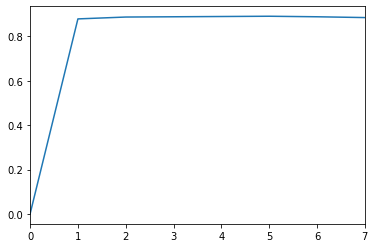

In [38]:
pd.Series(val_accuracy_history).plot()

## You should expect to get test accuracy >= 95.

In [39]:
# Reload best model from saved checkpoint
# Compute test accuracy
model = torch.load('best_model.pt')
test_accuracy = evaluate(model, test_loader)
print(test_accuracy)

TypeError: evaluate() missing 1 required positional argument: 'device'